# Evaluating Learning Curves

On this notebook we <b/>evaluate learning curves</b> to see whether we have reached a <b/>limit on model complexity</b> and <b/>training dataset size.</b>

We do this because, when that limit is reached, we need to <b/>work on a different model</b> instead of increasing the size of the dataset.

Our objective is to understand the posibility of getting better performance from our chosen logistic regression model, using the best features we identified earlier.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
from helpers import helpers
from sklearn.utils import resample
import warnings

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [4]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#dispaly all digits
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [5]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           9041        3438         894         183        4708        5119
Swap:          2047           0        2047


# Get Data

In [6]:
data = pd.read_csv('derived_data/engineered.csv')

print(data.shape)

(452670, 14)


In [15]:
data.sample(10)

,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_3_month,perf_6_month_avg,deck_risk_Yes,neg_inv_balance,lead_time_low,national_inv_low,in_transit_low,high_forecast,low_performance,went_on_backorder_Yes
42118,122.0,2.0,6.0,82.0,114.0,0.990000,0.0,0.0,1,0,0,1,0,0
107295,18.0,2.0,0.0,80.0,35.0,0.990000,0.0,0.0,1,0,1,1,0,0
86247,196.0,8.0,16.0,82.0,114.0,0.950000,0.0,0.0,0,0,0,1,0,0
367805,2.0,2.0,0.0,3.0,6.0,0.114805,0.0,0.0,1,1,1,0,1,1
86379,3.0,9.0,0.0,0.0,0.0,0.680000,0.0,0.0,0,1,1,0,1,0
151059,5.0,12.0,0.0,0.0,0.0,0.730000,0.0,0.0,0,1,1,0,1,0
21149,0.0,8.0,0.0,0.0,0.0,0.850000,0.0,0.0,0,1,1,0,0,0
281771,0.0,8.0,16.0,2.0,0.0,0.410000,1.0,0.0,0,1,0,0,1,0
354489,0.0,2.0,0.0,82.0,0.0,0.960000,0.0,0.0,1,1,1,1,0,1
64702,20.0,9.0,0.0,0.0,0.0,0.990000,0.0,0.0,0,0,1,0,0,0


In [7]:
#lets sample the size of our dataset to a manageable size
data = data.groupby('went_on_backorder_Yes').apply(lambda x: x.sample(frac=.1))
data = data.reset_index(drop=True)

print(data.shape)

(45267, 14)


In [8]:
#sanity check target class ratios
data['went_on_backorder_Yes'].value_counts()

0    30178
1    15089
Name: went_on_backorder_Yes, dtype: int64

In [9]:
#Get X and y
features = data.drop('went_on_backorder_Yes', axis=1)
target = data['went_on_backorder_Yes']

print(features.shape, target.shape)

(45267, 13) (45267,)


# Standardize Features

In [10]:
#get list of column names
column_names = []
for col in features.columns:
    column_names.append(col)
    
column_names

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'sales_3_month',
 'perf_6_month_avg',
 'deck_risk_Yes',
 'neg_inv_balance',
 'lead_time_low',
 'national_inv_low',
 'in_transit_low',
 'high_forecast',
 'low_performance']

In [11]:
features = features[column_names]

In [12]:
#get columns to stadardize
standard_cols = column_names[:6]

standard_cols

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'sales_3_month',
 'perf_6_month_avg']

In [13]:
#instantiate transformer object
ct = ColumnTransformer([
    ('standardize', StandardScaler(), standard_cols)
], remainder = 'passthrough')

In [14]:
#apply fit-transform
transformed_features = ct.fit_transform(features)

transformed_features

array([[ 0.96842142, -1.44338221,  3.07088433, ...,  0.        ,
         1.        ,  0.        ],
       [-0.41574929, -1.44338221, -0.38375532, ...,  1.        ,
         0.        ,  1.        ],
       [ 2.0384541 ,  0.35318904,  3.07088433, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [-0.50410061,  1.55090321, -0.38375532, ...,  1.        ,
         0.        ,  1.        ],
       [-0.47683674, -1.44338221,  0.09591665, ...,  0.        ,
         1.        ,  1.        ],
       [-0.46417352,  0.35318904, -0.38375532, ...,  1.        ,
         1.        ,  0.        ]])

In [15]:
#get transformed features dataframe
transformed_feats_df = pd.DataFrame(data = transformed_features, columns = [column_names])

transformed_feats_df.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_3_month,perf_6_month_avg,deck_risk_Yes,neg_inv_balance,lead_time_low,national_inv_low,in_transit_low,high_forecast,low_performance
0,0.968421,-1.443382,3.070884,2.297696,2.576553,0.073312,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
1,-0.415749,-1.443382,-0.383755,-0.595747,-0.574764,-1.247088,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2,2.038454,0.353189,3.070884,0.039399,2.576553,-0.916988,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
3,-0.513917,1.550903,-0.383755,-0.595747,-0.574764,-0.586888,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
4,-0.533551,0.353189,-0.383755,-0.207602,-0.574764,0.403412,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000


In [16]:
#get list of 8 features returned by step forward feature selector earlier
selected_feats = ['national_inv', 'in_transit_qty', 'forecast_3_month', 'sales_3_month',
                 'neg_inv_balance','national_inv_low', 'in_transit_low', 'high_forecast']

In [17]:
#select impactful features
transformed_feats_df = transformed_feats_df[selected_feats]

print(transformed_feats_df.shape, target.shape)

(45267, 8) (45267,)


In [18]:
transformed_feats_df.head()

,national_inv,in_transit_qty,forecast_3_month,sales_3_month,neg_inv_balance,national_inv_low,in_transit_low,high_forecast
0,0.968421,3.070884,2.297696,2.576553,0.000000,0.000000,0.000000,1.000000
1,-0.415749,-0.383755,-0.595747,-0.574764,0.000000,0.000000,1.000000,0.000000
2,2.038454,3.070884,0.039399,2.576553,0.000000,0.000000,0.000000,1.000000
3,-0.513917,-0.383755,-0.595747,-0.574764,0.000000,1.000000,1.000000,0.000000
4,-0.533551,-0.383755,-0.207602,-0.574764,0.000000,1.000000,1.000000,0.000000


In [19]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           9041        3446         876         193        4718        5101
Swap:          2047           0        2047


# Learning Curves

In [41]:
#call learning curve
#the 'train_sizes' arument divides our training set to specified training sizes here (50 samples in our case)
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(solver='saga'),
                                                        transformed_feats_df, target, cv=10,
                                                        scoring='average_precision', 
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.01, 1, 50),
                                                        verbose=1)

[learning_curve] Training set sizes: [  407  1230  2053  2876  3699  4522  5346  6169  6992  7815  8638  9461
 10284 11107 11931 12754 13577 14400 15223 16046 16869 17692 18515 19339
 20162 20985 21808 22631 23454 24277 25100 25923 26747 27570 28393 29216
 30039 30862 31685 32508 33331 34155 34978 35801 36624 37447 38270 39093
 39916 40740]


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.7s finished


In [42]:
#get mean value of training scores
#this returns training values of the 50 iterations (50 sub samples)
train_mean = np.mean(train_scores, axis=1)
train_mean

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.20933984, 0.38967024,
       0.49089098, 0.55690506, 0.60788711, 0.64508279, 0.67443385,
       0.70042968, 0.71969273, 0.73779688, 0.75308086, 0.76576385,
       0.77842807, 0.788789  , 0.79907116, 0.80754672, 0.81570433])

In [43]:
#get training scores standard deviations
#returns standard deviations of training scores in the 50 cross validation sets of ten iterations
train_std = np.std(train_scores, axis=1)
train_std

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.00632575, 0.00634242,
       0.00440259, 0.0025187 , 0.00203623, 0.00199122, 0.0017727 ,
       0.00170221, 0.00150911, 0.00178848, 0.00163937, 0.00155771,
       0.00133582, 0.00129359, 0.0012225 , 0.00112686, 0.00107744])

In [44]:
#get score means from the test set
test_mean = np.mean(test_scores, axis=1)
test_mean

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.82047326, 0.82161701,
       0.82116459, 0.82065856, 0.82068269, 0.8198901 , 0.81929842,
       0.81893868, 0.81819357, 0.81779538, 0.81732072, 0.81679112,
       0.81638558, 0.8161889 , 0.81609092, 0.8158283 , 0.81561034])

In [45]:
#note that these are average_precision scores
#get standard deviations on the test data
test_std = np.std(test_scores, axis=1)
test_std

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.0102241 , 0.01041598,
       0.01005863, 0.01012331, 0.01011043, 0.01011561, 0.0100067 ,
       0.00989016, 0.00985523, 0.00979035, 0.0097177 , 0.00958624,
       0.0094496 , 0.00937748, 0.00937367, 0.00933359, 0.00933897])

# Learning Curves

[]

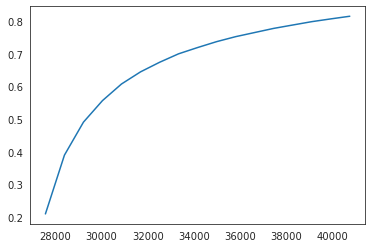

In [46]:
#plot training accuracy
plt.plot(train_sizes, train_mean)
plt.plot()

[]

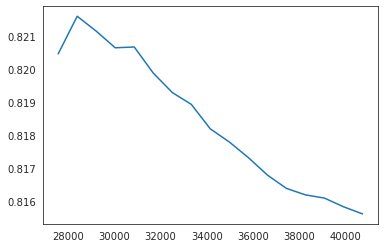

In [47]:
#plot the testing accuracy
plt.plot(train_sizes, test_mean)
plt.plot()

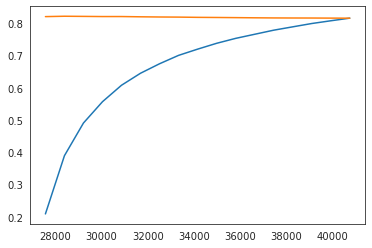

In [48]:
#plot both training and testing accuracy
plt.plot(train_sizes, train_mean)
plt.plot(train_sizes, test_mean)

Here we see that as we are increasing the training sample size, the testing accuracy is increasing(blue curve)

But the training accuracy is decreasing (orange curve)

This shows that increasing our sample size (training data) infinitely does not guarantee that our performance improves.

Meaning, <b/>there is a limit on the model complexity and size of the dataset from where we cannot increase or improve the accracy</b>.

When that limit is reached, we need to <b/>work on a different model</b> instead of increasing the size of the dataset.

That <b/>limit is when the train curve (blue) crosses the test accuracy curve(orange).</b>

In our case, the limit has been reached, meaning that choosing a different model could yied better results. 

We'll run a Linear Discriminant Analysis model

In [29]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:           9041        3351         983         169        4706        5220
Swap:          2047           0        2047


# Pretify Learning Curve Plots

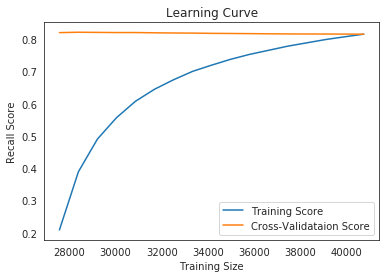

In [49]:
#Plot both training and testing accuracy
plt.plot(train_sizes, train_mean, label ='Training Score')
plt.plot(train_sizes, test_mean, label ='Cross-Validataion Score')


plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Recall Score')
plt.legend(loc = 'best')

### Adding Standard Deviation Plots

This will help us see how accuracy of the training and test varies through cross-validation folds 

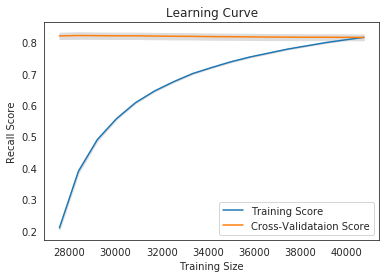

In [50]:
#Plot both training and testing accuracy
plt.plot(train_sizes, train_mean, label ='Training Score')
plt.plot(train_sizes, test_mean, label ='Cross-Validataion Score')

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color= '#DDDDDD')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, color= '#DDDDDD')


plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Recall Score')
plt.legend(loc = 'best')

# Analysis Summary

The training and test learning curves meet meet at around 40,000 samples

This means, increasing the training size for the logistic regression model with this data is not likely to improve performance.

We'll keep this in mind as we proceed with next modeling steps.